# Sparkify project

## Instantiate notebook

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import row_number, rank, isnan, count, when, col, desc, udf, col, sort_array, asc, avg, lit, substring, from_unixtime
from pyspark.sql.types import Row, DateType, TimestampType
from pyspark.sql.window import Window
from pyspark.sql import functions as func
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
pd.options.display.mpl_style = 'default'

import numpy as np

In [2]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

## Load dataset

In [3]:
# Read in full sparkify dataset
event_data = "mini_sparkify_event_data.json" # mini-dataset
df = spark.read.json(event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

## Exploratory Data Analysis

### Data layout

|Column|Description|
|-----|-----|
|artist|Artist listened to (17656 different artists)|
|auth|Authentification status (Logged in, logged out, Guest, Cancelled)|
|firstName|First name of user|
|gender|Gender of user|
|itemInSession|Number of the current item in the session (does not always start with 1)|
|lastName|Last name of user|
|length|duration for which a song played (only for page 'NextSong', else NaN)|
|level|free vs. paid user. ? Can the status change for one user?|
|location|Location of the user|
|method|PUT vs GET???|
|page|page on which the user event happens|
|registration|Timestamp of the user registration|
|sessionId|Id of the current logon session of the user|
|song|Song the customer plays (only for page 'NextSong', else None); 58490 different songs|
|status|unknown meaning|
|ts|timestamp, when the item occurs|
|userAgent|Intrerface/Webbrowser used by the customer|
|userId|ID of the customer|

In [5]:
# Inspect column names and datatypes
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [22]:
def get_df_shape(df):
    """
        Gets row and column counts of a spark-dataframe as tuples
        Input:
            df (pyspark.sql.dataframe.DataFrame): dataframe
        Output:
            tuple: (<row count>,<column count>)
    """
    return (df.count(), len(df.columns))

In [34]:
df_shape = get_df_shape(df)
print("Rows:\t\t{:7,}\nColumns:\t{:7,}".format(df_shape[0],df_shape[1]))

Rows:		286,500
Columns:	     18


In [21]:
print((df.count(), len(df.columns)))

(286500, 18)


### Data inspection

In [18]:
# Inspect first 20 rows in DataFrame
first_events = df.limit(5).toPandas()
first_events

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [20]:
def pandas_df_to_markdown_table(df):
    """
        Prints a dataframe as markdown
        Input:
            df (pd.DataFrame): Dataframe to print as markdown
    """
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    print(df_formatted.to_csv(sep="|", index=False))

pandas_df_to_markdown_table(first_events)

artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|ts|userAgent|userId
---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
Martha Tilston|Logged In|Colin|M|50|Freeman|277.89016|paid|Bakersfield, CA|PUT|NextSong|1538173362000|29|Rockpools|200|1538352117000|Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0|30
Five Iron Frenzy|Logged In|Micah|M|79|Long|236.09424|free|Boston-Cambridge-Newton, MA-NH|PUT|NextSong|1538331630000|8|Canada|200|1538352180000|"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"""|9
Adam Lambert|Logged In|Colin|M|51|Freeman|282.8273|paid|Bakersfield, CA|PUT|NextSong|1538173362000|29|Time For Miracles|200|1538352394000|Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0|30
Enigma|Logged In|Micah|M|80|Long|262.71302|free|Boston-Cambridge-Newton, MA-NH|PUT|NextSong|15383316300

In [85]:
# Inspect string features
def inspect_string_features(df, top_x = 10):
    """
        Plots top x most frequent features of string columns in a pyspark.sql.dataframe.DataFrame
        Input:
            df (pyspark.sql.dataframe.DataFrame): dataframe to be inspected
            top_x: number of top count features to be displayed
        
    """
    string_features = [t[0] for t in df.dtypes if t[1] == 'string']
    fig, ax = plt.subplots(len(string_features),1, figsize=(20,80))
    for i, string_feature in enumerate(string_features):
        values = df.groupBy(string_feature).count().sort(desc('count')).toPandas()
        top_values = values[:top_x]
        y_pos = np.arange(top_values.shape[0])        
        ax[i].barh(y_pos, top_values['count'])
        ax[i].set_yticks(y_pos)
        ax[i].set_yticklabels(top_values[string_feature])
        ax[i].invert_yaxis()  # labels read top-to-bottom
        ax[i].set_xlabel('Count')
        ax[i].set_title("Top {} values (out of {}) of string feature '{}':".format(top_x,values.shape[0],string_feature))
    
    plt.tight_layout()
    plt.show()
    return fig, ax    

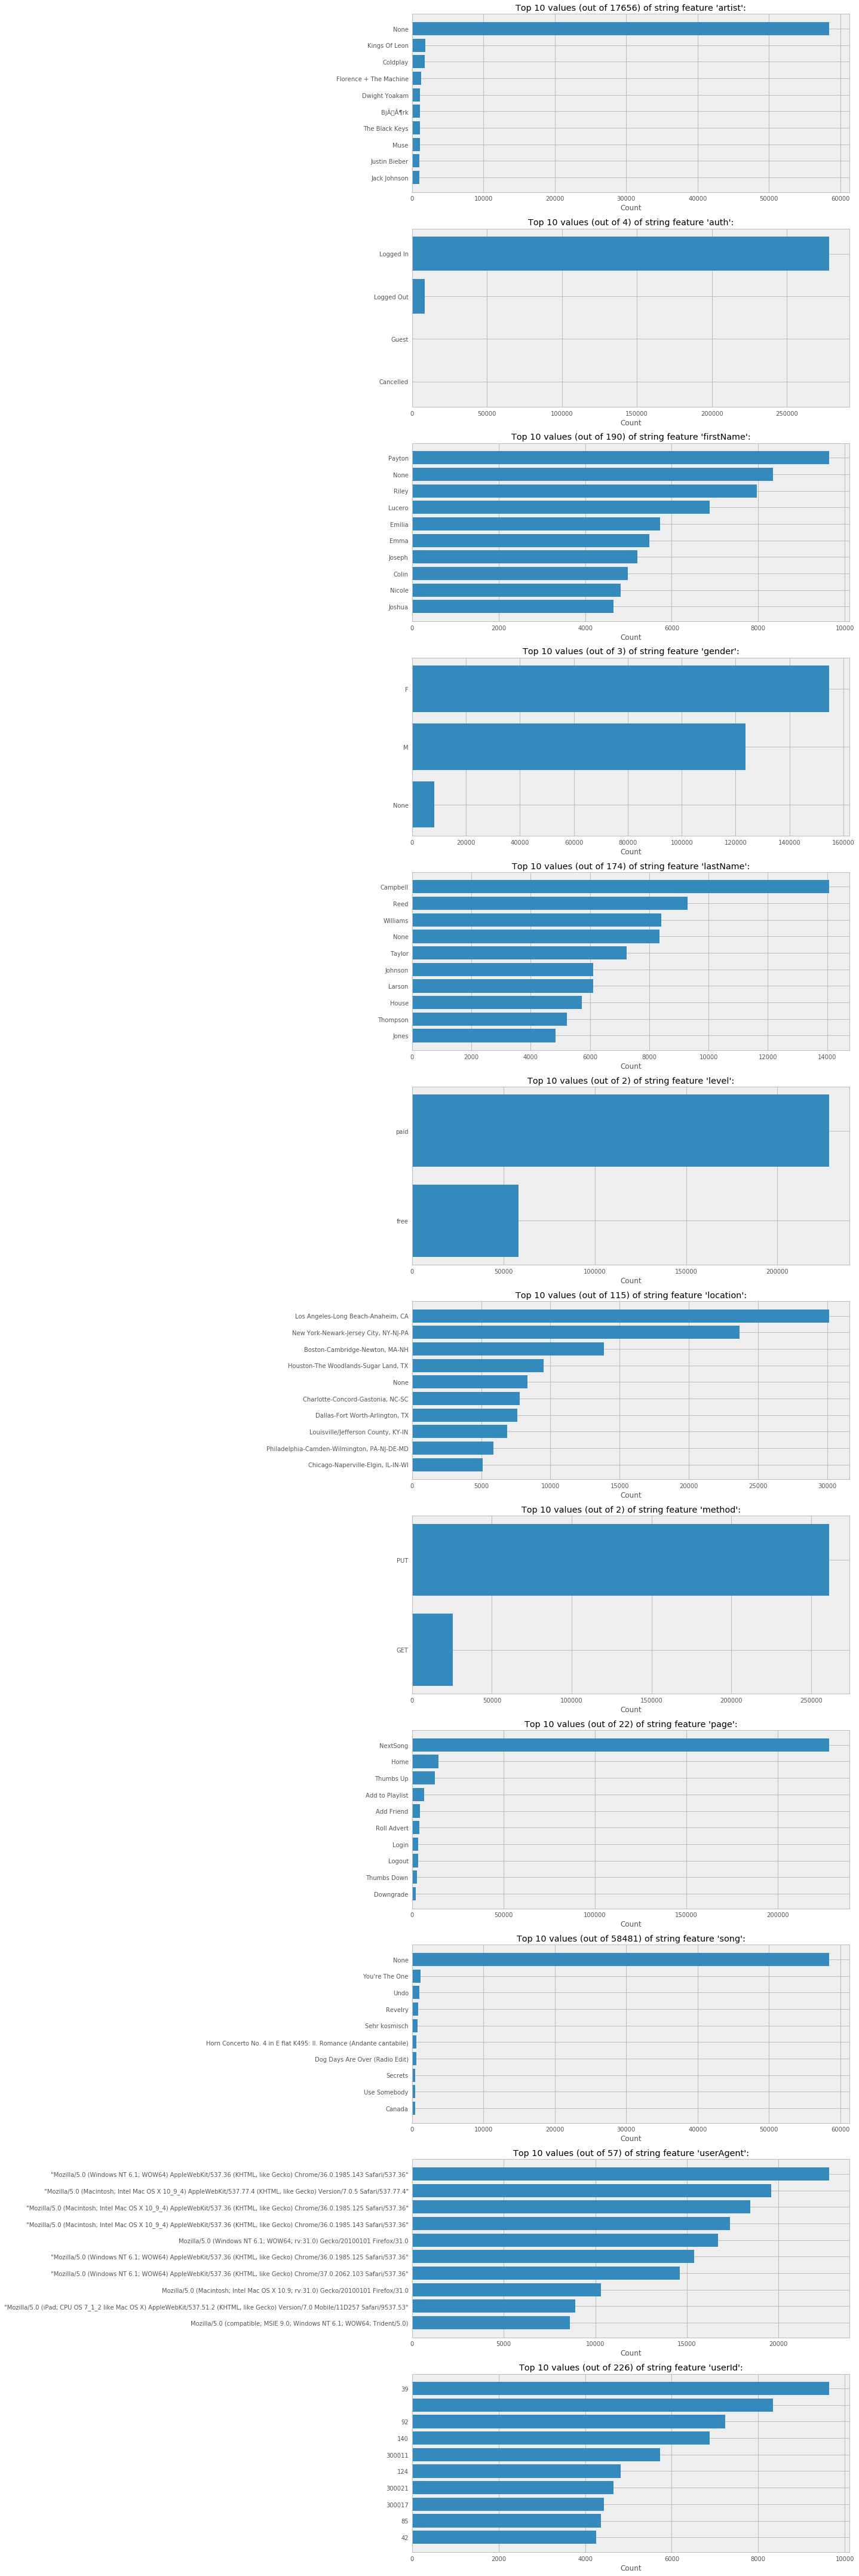

In [87]:
fig, ax = inspect_string_features(df)

In [81]:
def inspect_numeric_features(df,sample_size=0.1, save=False, save_path=None):
    """
        Plots distributions and correlation scatters for numeric columns in a pyspark.sql.dataframe.DataFrame
        Input:
            df (pyspark.sql.dataframe.DataFrame): dataframe to be inspected
            sample_size: number of samples from the dataframe
            save (bool): determines whether figure should be saved
            save_path (str): path to save the figure to
    """
    numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double' or t[1] == 'bigint']
    sampled_data = df.select(numeric_features).sample(False, sample_size).toPandas()

    axs = pd.scatter_matrix(sampled_data, figsize=(12, 12));

    # Rotate axis labels and remove axis ticks
    n = len(sampled_data.columns)
    for i in range(n):
        v = axs[i, 0]
        v.yaxis.label.set_rotation(0)
        v.yaxis.label.set_ha('right')
        v.set_yticks(())
        h = axs[n-1, i]
        h.xaxis.label.set_rotation(90)
        h.set_xticks(())
    if save:
        plt.tight_layout()
        plt.savefig(save_path)

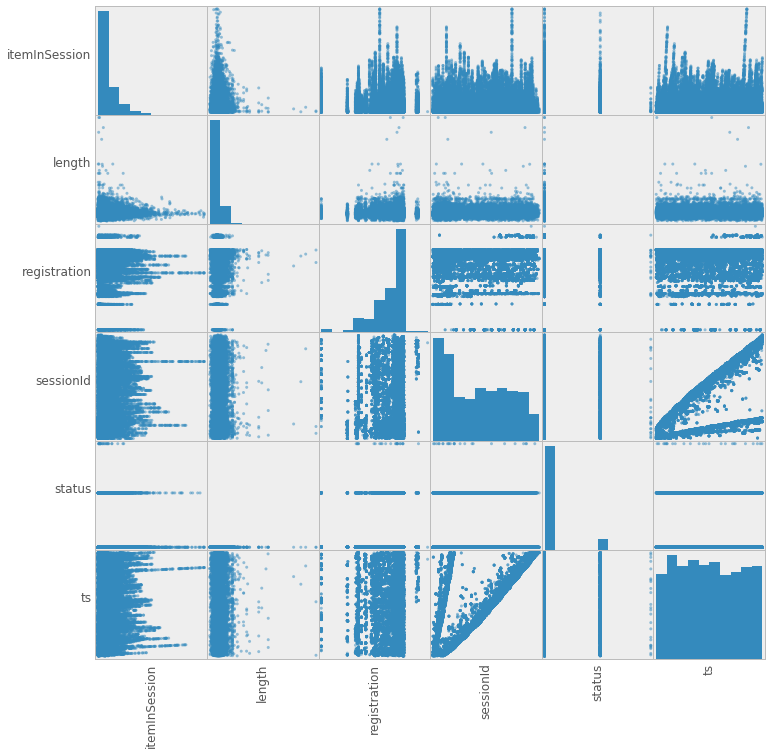

In [88]:
inspect_numeric_features(df)

In [27]:
# Inquire one UserID
df.filter(df.userId==30).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
2,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
4,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
6,Edward Sharpe & The Magnetic Zeros,Logged In,Colin,M,56,Freeman,223.58159,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Jade,200,1538353218000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
7,Stan Mosley,Logged In,Colin,M,57,Freeman,246.69995,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,So-Called Friends,200,1538353441000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,Orishas,Logged In,Colin,M,58,Freeman,222.22322,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Represent,200,1538353687000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Downhere,Logged In,Colin,M,59,Freeman,223.92118,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Here I Am,200,1538353909000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### Data cleaning and preprocessing

In [35]:
w = Window().partitionBy("userId").orderBy(col("ts").desc())

df_cleaned = (df
              .filter(df.userId!='') # Remove rows without UserIds (typically in auth=Logged Out)
              .withColumn('ts_timestamp', from_unixtime((col('ts')/1000)).cast(TimestampType())) # Transform ts to readable format
              .withColumn('registration_timestamp', from_unixtime((col('registration')/1000)).cast(TimestampType())) # Transform registration to readable format
              .withColumn('overallDaysAsCustomer', ((func.max(df['ts']).over(w)-func.min(df['registration']).over(w))/(1000* (60*60*24)))) # Calculate overall days as a customer
              .withColumn("daysSinceRegistration", (df.ts - df.registration)/(1000* (60*60*24))) # Calculate days since registration
              .withColumn("daysToLastInteraction", (func.max(df['ts']).over(w) - df['ts'])/(1000* (60*60*24))) # Calculate days to last interaction
             )

### Data inspection after cleaning

In [5]:
df_cleaned.limit(10).toPandas()

,0,1,2,3,4,5,6,7,8,9
artist,None,Lily Allen,John Waite,Hermano,None,Hot Chip,Eminem,The Police,Ke$ha,Gwen Stefani
auth,Logged In,Logged In,Logged In,Logged In,Logged In,Logged In,Logged In,Logged In,Logged In,Logged In
firstName,Darianna,Darianna,Darianna,Darianna,Darianna,Darianna,Darianna,Darianna,Darianna,Darianna
gender,F,F,F,F,F,F,F,F,F,F
itemInSession,34,33,32,31,30,29,28,27,26,25
lastName,Carpenter,Carpenter,Carpenter,Carpenter,Carpenter,Carpenter,Carpenter,Carpenter,Carpenter,Carpenter
length,NaN,185.26,269.766,115.905,NaN,319.425,302.576,305.058,207.647,264.933
level,free,free,free,free,free,free,free,free,free,free
location,"Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT"
method,PUT,PUT,PUT,PUT,GET,PUT,PUT,PUT,PUT,PUT


In [40]:
df_shape = get_df_shape(df_cleaned)
n_users = df_cleaned.select('userId').dropDuplicates().count()
print("Rows:\t\t\t\t{:7,}\nColumns:\t\t\t{:7,}".format(df_shape[0],df_shape[1]))
print("Number of users: \t\t{:7,}".format(n_users))
print("Average events per user: \t{:7,.0f}".format(df_shape[0]/n_users))

Rows:				278,154
Columns:			     23
Number of users: 		    225
Average events per user: 	  1,236


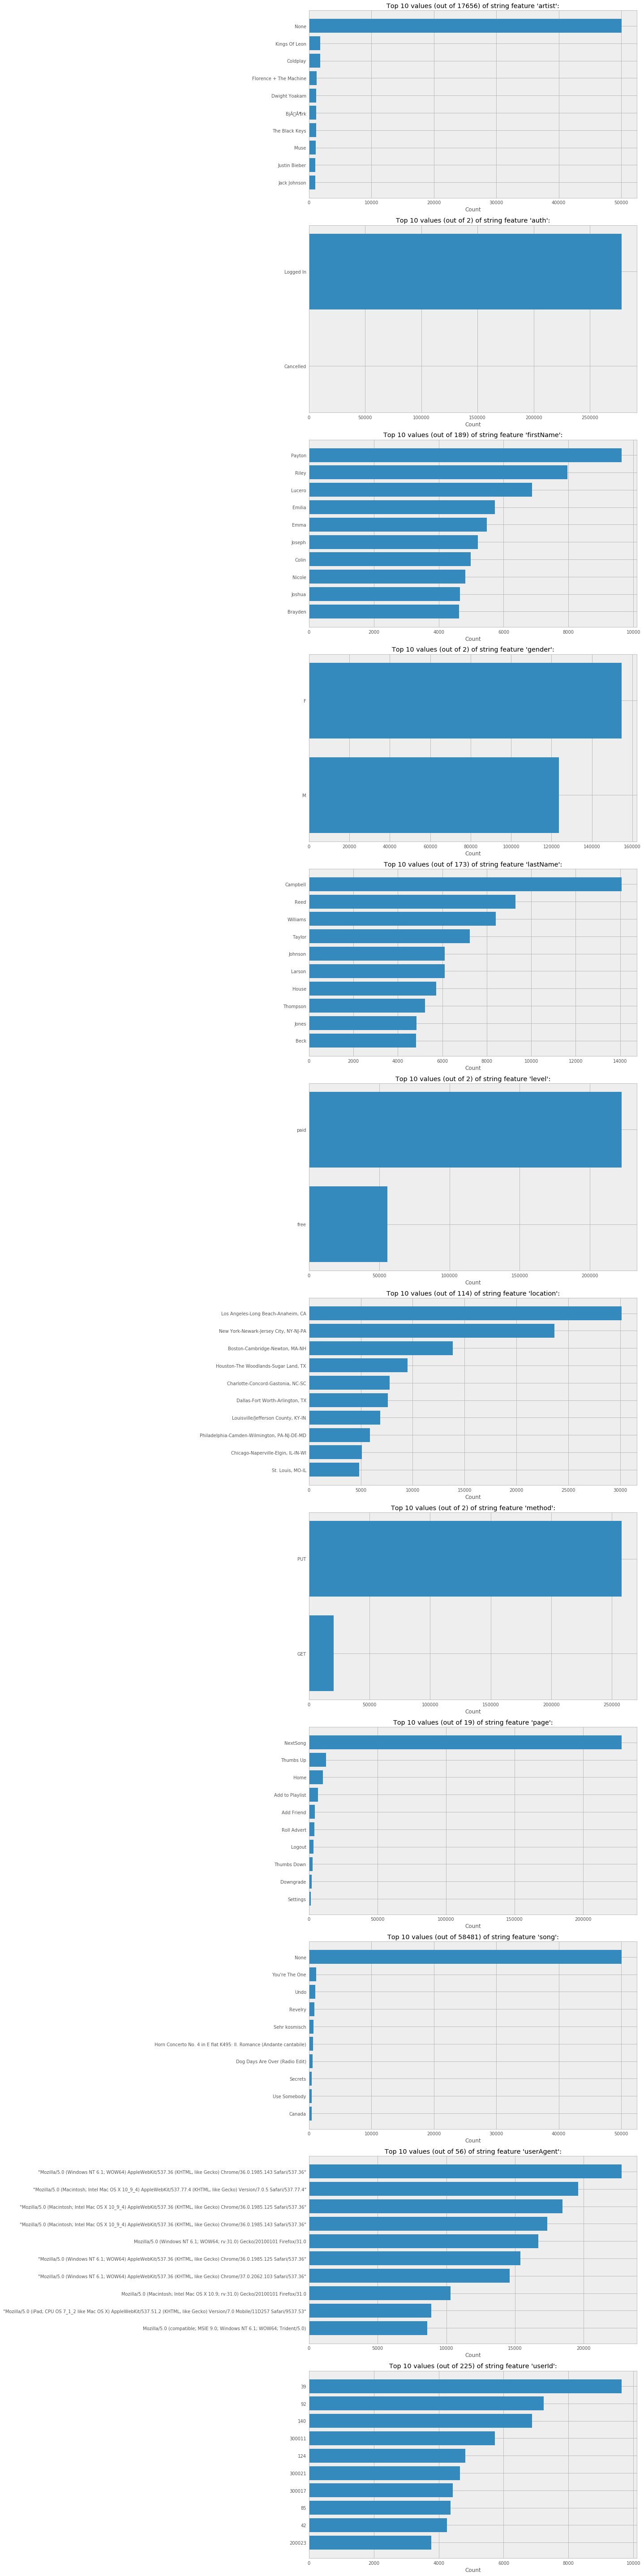

In [84]:
fig, ax = inspect_string_features(df_cleaned)

In [86]:
fig.savefig('string_features.png')

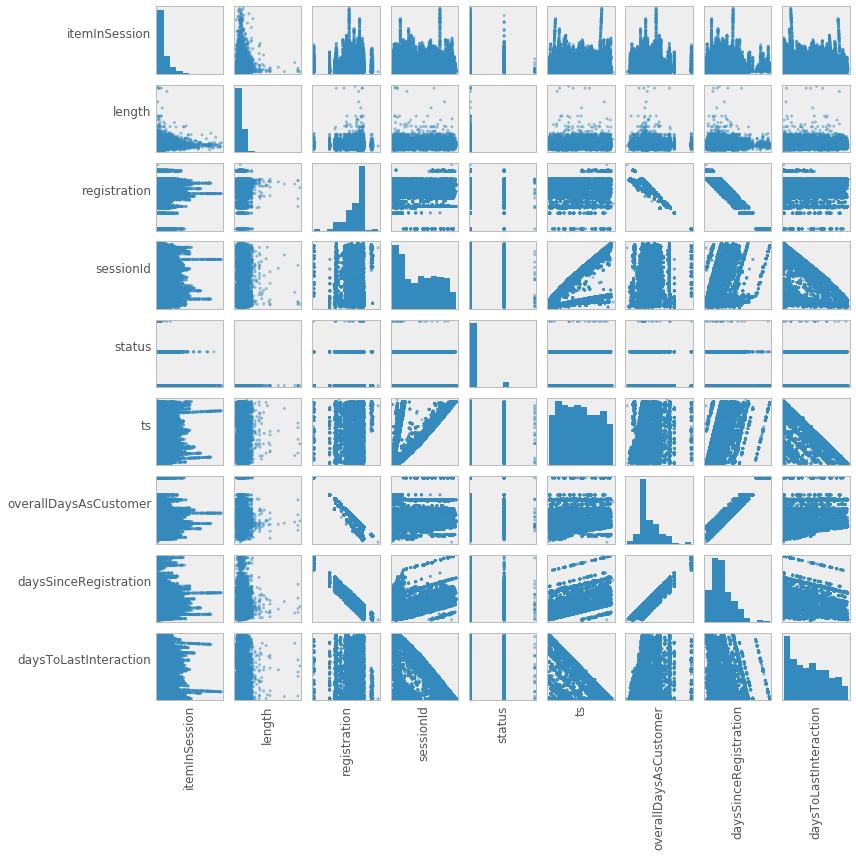

In [82]:
inspect_numeric_features(df_cleaned, save=True, save_path = 'numeric_features.png')

## Churn definition

In [89]:
# Identify df with all userId
df_all_ids = df_cleaned.select('userId').dropDuplicates()

# Create Df with all userIds containing cancellation confirmation
df_cancel_conf_ids = df_cleaned.filter(df_cleaned.page =='Cancellation Confirmation').select('userId').dropDuplicates().withColumn('label', lit(1))

# Left Join von df_all_ids on df_cancellation_confirmation with fillna with False
df_churn = df_all_ids.join(df_cancel_conf_ids,on='userId', how='left').fillna(0)

In [90]:
n_churn = df_churn.groupby('label').count().toPandas()
n_churn

,label,count
0,1,52
1,0,173


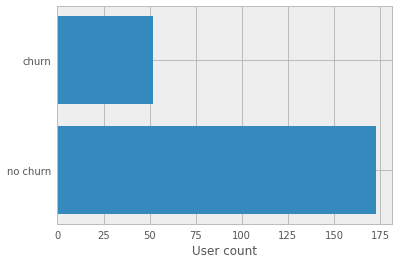

In [93]:
fig, ax = plt.subplots()
y_pos = np.arange(n_churn.shape[0])        
ax.barh(y_pos, n_churn['count'])
ax.set_yticks(y_pos)
ax.set_yticklabels(['churn','no churn'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('User count')
fig.savefig('churn.png')

## Feature Engineering
Features implemented:
* artists
  * f01: number of artists listened to
* gender
  * f02: user gender
* level
  * f03: current user level
* page
  * f04: songs played overall
  * f05: (average number of songs played per day (last 7 days)) / (average number of songs played per day (overall))
  * f06: number of downgrades last 7 days
  * f07: number of upgrades last 7 days
  * f08: number of thumbs up last 7 days
  * f09: number of thumbs down last 7 days
  * f10: number of add friend last 7 days
  * f11: number of add to playlist last 7 days
  * f12: number of roll advert last 7 days
* length
  * f13: average length listened to a song
  * f14: length trend: (average length listened to a song (last 7 days) / average length listened to a song (overall)) * (7 / overall days)
* ts
  * f15: number of days as a customer
* sessionId
  * f16: (average number of sessions per day (last 7 days)) / (average number of sessions per day (overall))

### f01: number of artists listened to

In [94]:
f01 = df_cleaned.select('userId','artist').dropDuplicates().groupBy('userId').count().selectExpr('userId as userId', "Count as n_artisted_listened")

### f02: Gender

In [95]:
f02 = (df_cleaned
 .select('userId','gender')
 .dropDuplicates()
 .replace(["M", "F"], ["0", "1"], "gender")
)

f02 =  f02.withColumn("gender", f02["gender"].cast(IntegerType()))

### f03: current user level

In [96]:
w = Window().partitionBy("userId").orderBy(col("ts").desc())

f03 = (df_cleaned
      .withColumn("rn", row_number().over(w))
      .where(col("rn") == 1)
      .select("userId", "level")
      .replace(["free", "paid"], ["0", "1"], "level"))

f03 =  f03.withColumn("level", f03["level"].cast(IntegerType()))

### f04: songs played overall

In [97]:
f04 = (df_cleaned
       .select('userId','page')
       .where(df_cleaned.page=='NextSong')
       .groupBy('userId')
       .count()
       .selectExpr('userId as userId', "Count as n_songs_played")
      )

### f05: Average number of songs played per day (last 7 days) / overall

In [98]:
avg_number_of_songs_overall = (df_cleaned
                                  .select('userId','overallDaysAsCustomer', 'page')
                                  .filter(df_cleaned.page=='NextSong')
                                  .groupBy('userId','overallDaysAsCustomer')
                                  .count()
                                  .sort(desc('count'))
                                 )
avg_number_of_songs_overall = (avg_number_of_songs_overall
                                  .withColumn('avg_n_songs_overall', avg_number_of_songs_overall['count']/avg_number_of_songs_overall['overallDaysAsCustomer'])
                                  .drop('count','overallDaysAsCustomer')
                                 )

In [99]:
avg_number_of_songs_last7 = (df_cleaned
                                  .select('userId','daysToLastInteraction', 'page')
                                  .filter((df_cleaned.daysToLastInteraction<=7)&(df_cleaned.page=='NextSong'))
                                  .groupBy('userId')
                                  .count()
                                  .sort(desc('count'))
                                 )
avg_number_of_songs_last7 = (avg_number_of_songs_last7
                             .withColumn('avg_n_songs_last7', avg_number_of_songs_last7['count']/(7))
                             .drop('count')
                            )

In [100]:
f05 = avg_number_of_songs_overall.join(avg_number_of_songs_last7,on='userId', how='inner')
f05 = (f05
       .withColumn('songRatio', f05['avg_n_songs_last7']/f05['avg_n_songs_overall'])
       .drop('avg_n_songs_last7', 'avg_n_songs_overall')
      )

### f06: number of downgrades last 7 days

In [101]:
def count_events_per_user(df, count_column, count_value, last_x_days, feature_name):
    """
        Counts occurences of one value in one column per user for a given timeframe back from the last event of the user
        Input:
            df (pyspark.sql.dataframe.DataFrame): dataframe to be inspected
            count_column (str): name of the column containing the values to be counted
            count_value: value which occurences should be counted
            last_x_days (float): number of days to be considered before last event of the user
            feature_name (str): name of the feature column in the returned dataframe
        Output:
            pyspark.sql.dataframe.DataFrame: Contains userId and feature column containing the counting results
    """
    fxx = (df
          .select('userId', count_column)
          .filter((df_cleaned.daysToLastInteraction<=last_x_days)&(df_cleaned.page==count_value))
          .groupBy('userId')
          .count()
          .selectExpr("userId as userId", "count as {}".format(feature_name))
          )
    return fxx

In [102]:
f06 = count_events_per_user(df_cleaned, 'page', 'Downgrade',7,'n_downgrades_last7')

In [103]:
f06.limit(5).toPandas().T

,0,1,2,3,4
userId,200002,124,51,15,54
n_downgrades_last7,2,4,11,6,13


### f07: number of upgrades last 7 days

In [104]:
f07 = count_events_per_user(df_cleaned, 'page', 'Upgrade',7,'n_upgrades_last7')

### f08: number of thumbs up last 7 days

In [105]:
f08 = count_events_per_user(df_cleaned, 'page', 'Thumbs Up',7,'n_thumbs_up_last7')

### f09: number of thumbs down last 7 days

In [106]:
f09 = count_events_per_user(df_cleaned, 'page', 'Thumbs Down',7,'n_thumbs_down_last7')

### f10: number of add friend last 7 days

In [107]:
f10 = count_events_per_user(df_cleaned, 'page', 'Add Friend',7,'n_add_friend_last7')

### f11: number of add to playlist last 7 days

In [108]:
f11 = count_events_per_user(df_cleaned, 'page', 'Add to Playlist',7,'n_add_playlist_last7')

### f12: number of roll advert last 7 days

In [109]:
f12 = count_events_per_user(df_cleaned, 'page', 'Roll Advert',7,'n_roll_advert_last7')

### f13: average length listened to a song

In [110]:
f13 = (df_cleaned
       .select('userId','length', 'page')
       .filter(df_cleaned.page=='NextSong')
       .groupBy('userId')
       .mean()
       .select(col("userId"), col("avg(length)").alias("average_length"))
      )

### f14: length trend: (average length listened to a song last 7 days / average length all songs) (7 / overall days)

In [111]:
avg_length_overall = f13.select(col("userId"), col("average_length").alias("average_length_overall"))

In [112]:
avg_length_last7 = (df_cleaned
       .select('userId','length', 'page','overallDaysAsCustomer')
       .filter((df_cleaned.daysToLastInteraction<=7) & (df_cleaned.page=='NextSong'))
       .groupBy('userId','overallDaysAsCustomer')
       .mean()
       .select(col("userId"), col('overallDaysAsCustomer'), col("avg(length)").alias("average_length_last7"))
      )

In [113]:
f14 = avg_length_overall.join(avg_length_last7,on='userId', how='inner')
f14 = (f14
       .withColumn('lengthRatio', (f14['average_length_last7']/f14['average_length_overall'])*(7/f14['overallDaysAsCustomer']))
       .drop('average_length_overall', 'overallDaysAsCustomer', 'average_length_last7')
      )

### f15: number of days as a customer

In [114]:
f15 = (df_cleaned
       .select('userId','overallDaysAsCustomer')
       .dropDuplicates()
      )

### f16: average number of sessions per day past 7 days / average number of sessions per day overall

In [115]:
avg_number_of_sessions_overall = (df_cleaned
                                  .select('userId','overallDaysAsCustomer','sessionId')
                                  .dropDuplicates()
                                  .groupBy('userId','overallDaysAsCustomer')
                                  .count()
                                 )
avg_number_of_sessions_overall = (avg_number_of_sessions_overall
                                  .withColumn('avg_n_sessions_overall', avg_number_of_sessions_overall['count']/avg_number_of_sessions_overall['overallDaysAsCustomer'])
                                  .drop('count','overallDaysAsCustomer')
                                 )

In [116]:
avg_number_of_sessions_past7 = (df_cleaned
                                .filter(df_cleaned.daysToLastInteraction<=7)
                                  .select('userId','overallDaysAsCustomer','sessionId')
                                  .dropDuplicates()
                                  .groupBy('userId','overallDaysAsCustomer')
                                  .count()
                                 )
avg_number_of_sessions_past7 = (avg_number_of_sessions_past7
                                  .withColumn('avg_n_sessions_past7', avg_number_of_sessions_past7['count']/7)
                                  .drop('count','overallDaysAsCustomer')
                                 )

In [117]:
f16 = avg_number_of_sessions_overall.join(avg_number_of_sessions_past7,on='userId', how='inner')
f16 = (f16
       .withColumn('sessionRatio', (f16['avg_n_sessions_past7']/f16['avg_n_sessions_overall']))
       .drop('avg_n_sessions_past7', 'avg_n_sessions_overall', 'overallDaysAsCustomer')
      )

### Merge all features

In [118]:
feature_dataframes_to_merge = [f01,
                               f02,
                                  f03,
                                  f04,
                                  f05,
                                  f06,
                                  f07,
                                  f08,
                                  f09,
                                  f10,
                                  f11,
                                  f12,
                                  f13,
                                  f14,
                                  f15,
                                  f16
                                 ]

In [119]:
df_features = df_churn
for feature_dataframe_to_merge in feature_dataframes_to_merge:
    df_features = df_features.join(feature_dataframe_to_merge,on='userId',how='left')

df_features = df_features.fillna(0)  # Required for counted values like upgrades. If no upgrade exists there is no row in the feature dataframe

In [120]:
df_features.limit(5).toPandas().T

,0,1,2,3,4
userId,100010,200002,125,124,51
label,0,0,1,0,1
n_artisted_listened,253,340,9,2233,1386
gender,1,0,0,1,0
level,0,1,0,1,1
n_songs_played,275,387,8,4079,2111
songRatio,0.693739,3.10408,10.1881,1.04589,1.26265
n_downgrades_last7,0,2,0,4,11
n_upgrades_last7,1,0,0,0,0
n_thumbs_up_last7,2,6,0,14,47


## Modeling

### Preprocess for machine learning

In [121]:
input_columns = df_features.columns[2:]

In [122]:
assembler = VectorAssembler(inputCols=input_columns, outputCol="features_tmp")
scaler = StandardScaler(inputCol="features_tmp", outputCol="features")

pipeline = Pipeline(stages=[assembler, scaler])

In [123]:
data_model = pipeline.fit(df_features).transform(df_features)
data_model = data_model.select('userId','features','label')

In [124]:
# Split data into training and test set
data_train, data_test = data_model.randomSplit([0.8, 0.2], seed=42)

In [125]:
data_train.limit(5).toPandas().T

,0,1,2,3,4
userId,100010,125,124,7,54
features,"[0.418904011017, 2.00127105192, 0.0, 0.2488776...","(0.0149017237121, 0.0, 0.0, 0.00724007598756, ...","[3.69728322767, 2.00127105192, 2.08442500134, ...","[0.236771832314, 0.0, 0.0, 0.135751424767, 0.3...","[2.88927865306, 2.00127105192, 2.08442500134, ..."
label,0,1,0,0,1


In [126]:
type(data_train)

pyspark.sql.dataframe.DataFrame

### Build and evaluate models

In [50]:
def evaluate_model(model, data_test, model_name):
    """
        Evaluates model calculating metrics based on train and test data
        Input:
            model (classifier): Trained classifier
            data_test (pyspark.sql.dataframe.DataFrame): Testing data
            model_name (str): Name of the model
        Output:
            pyspark.sql.dataframe.DataFrame: test results
            float: test accuracy
            float: test f1-score
    """
    
    test_result = model.transform(data_test)
    
    # Calculate accuracy and F-1 score
    accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = accuracy_evaluator.evaluate(test_result.select(col('label'), col('prediction')))

    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(test_result.select(col('label'), col('prediction')))

    print('{}\nAccuracy test:\t{:.5f}\nF-1 score:\t{:.5f}\n'.format(model_name, accuracy, f1_score))
    
    return test_result, accuracy, f1_score

#### Logistic regression

In [51]:
classifier = LogisticRegression()
model_lr = classifier.fit(data_train)

In [52]:
test_results_lr, accuracy_lr, f1_score_lr = evaluate_model(model_lr, data_test, 'LOGISTIC REGRESSION')

LOGISTIC REGRESSION
Accuracy test:	0.91176
F-1 score:	0.90399



#### Random Forest

In [53]:
classifier = RandomForestClassifier()
model_rf = classifier.fit(data_train)

In [54]:
test_results_rf, accuracy_rf, f1_score_rf = evaluate_model(model_rf, data_test, 'RANDOM FOREST')

RANDOM FOREST
Accuracy test:	0.85294
F-1 score:	0.83998



#### Gradient boosting

In [55]:
classifier = GBTClassifier()
model_gbt = classifier.fit(data_train)

In [56]:
test_results_gbt, accuracy_gbt, f1_score_gbt = evaluate_model(model_gbt, data_test, 'GRADIENT BOOSTING')

GRADIENT BOOSTING
Accuracy test:	0.73529
F-1 score:	0.72897

